# Imports and environment


In [40]:
import sys
import os
import warnings
import mne

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from mne.decoding import CSP, PSDEstimator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import scripts.multi_task.linear as linear
import scripts.multi_task.linear_data_selection as linear_ds
from scripts.features_extract.welch import extract_welch_features
from eeg_logger import logger

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")

# Instantiate dataset

**Datased used is BCI Competition IVa**


In [41]:
dataset = BNCI2014_001()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
paradigm = LeftRightImagery(channels=None)
data = dataset.get_data(subjects=[1])
data[1]["0train"]["0"]

<RawArray | 26 x 96735 (386.9 s), ~19.2 MiB, data loaded>

# Create pipelines for SVM and LDA

**1** - CSP + SVM  
**2** - PSD + LDA


In [3]:
pipelines = {
    "csp+svm": make_pipeline(CSP(n_components=6), SVC(kernel="linear")),
    "psd+lda": make_pipeline(
        PSDEstimator(fmin=7, fmax=31, sfreq=250),
        FunctionTransformer(lambda X: X.reshape(X.shape[0], -1)),
        LDA(),
    ),
}

# Evaluate


In [4]:
evaluation = CrossSessionEvaluation(paradigm=paradigm, datasets=[dataset], overwrite=True)
results = evaluation.process(pipelines)
results = results[results["session"] == "1test"]
results

2025-07-08 10:37:19,051 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]2025-07-08 10:37:21,886 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 1 | 0train: Score 0.952
2025-07-08 10:37:22,278 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 1 | 1test: Score 0.974
2025-07-08 10:37:23,077 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 1 | 0train: Score 0.791
2025-07-08 10:37:23,879 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 1 | 1test: Score 0.691
BNCI2014-001-CrossSession:  11%|█         | 1/9 [00:04<00:39,  4.96s/it]2025-07-08 10:37:26,810 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 2 | 0train: Score 0.551
2025-07-08 10:37:27,200 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 2 | 1test: Score 0.628
2025-07-08 10:37:27,962 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 2 | 0train:

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
1,0.974151,0.263007,144.0,1,1test,22,2,BNCI2014-001,csp+svm
3,0.628086,0.256038,144.0,2,1test,22,2,BNCI2014-001,csp+svm
5,0.993441,0.281450,144.0,3,1test,22,2,BNCI2014-001,csp+svm
7,0.836227,0.281003,144.0,4,1test,22,2,BNCI2014-001,csp+svm
9,0.611690,0.275038,144.0,5,1test,22,2,BNCI2014-001,csp+svm
11,0.783565,0.254026,144.0,6,1test,22,2,BNCI2014-001,csp+svm
13,0.885417,0.269998,144.0,7,1test,22,2,BNCI2014-001,csp+svm
15,0.994792,0.281001,144.0,8,1test,22,2,BNCI2014-001,csp+svm
17,0.970100,0.255004,144.0,9,1test,22,2,BNCI2014-001,csp+svm
19,0.690779,0.662271,144.0,1,1test,22,2,BNCI2014-001,psd+lda


# Plot SVM and LDA classifier results


(0.5, 1.0)

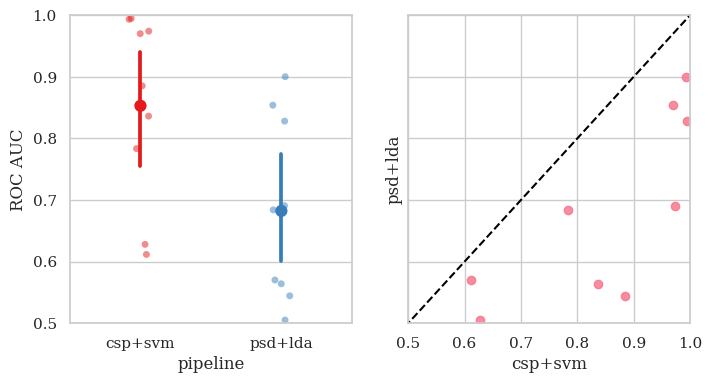

In [5]:
fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=axes[0], palette="Set1")

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

paired = results.pivot_table(values="score", columns="pipeline", index=["subject", "session"])
paired = paired.reset_index()

sns.regplot(data=paired, y="psd+lda", x="csp+svm", ax=axes[1], fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)

# Preparing train and test data

Dataset is first divided into train and test data.  
Feature extraction is done using Welch's method, which estimates PSD for each channel.


In [3]:
X_all, y_all, metadata = paradigm.get_data(dataset, subjects=dataset.subject_list, return_epochs=False)
subjects = metadata["subject"].unique()
sessions = metadata["session"].unique()

X_train = np.empty(len(subjects), dtype=object)
X_test = np.empty(len(subjects), dtype=object)
y_train = np.empty(len(subjects), dtype=object)
y_test = np.empty(len(subjects), dtype=object)
label_map = {"left_hand": -1, "right_hand": 1}

for idx, subject in enumerate(subjects):

    train_mask = (metadata["subject"] == subject) & (metadata["session"] == "0train")
    test_mask = (metadata["subject"] == subject) & (metadata["session"] == "1test")

    X_sess_train = X_all[train_mask]
    y_sess_train = y_all[train_mask]
    X_sess_test = X_all[test_mask]
    y_sess_test = y_all[test_mask]

    X_train_feat = extract_welch_features(X_sess_train)
    X_test_feat = extract_welch_features(X_sess_test)
    y_sess_train = np.array([label_map[label] for label in y_sess_train])
    y_sess_test = np.array([label_map[label] for label in y_sess_test])

    X_train[idx] = X_train_feat.T
    X_test[idx] = X_test_feat.T
    y_train[idx] = y_sess_train.reshape(-1, 1)
    y_test[idx] = y_sess_test.reshape(-1, 1)

2025-07-08 13:14:41,257 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:42,694 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:44,148 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:45,566 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:46,979 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:48,421 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:49,833 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:51,208 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:52,611 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:54,004 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:55,466 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-08 13:14:56,887 - INFO - Welch features extrac

# Testing linear multi-task classifier (Algorithm 1)

First, classifier learns basic prior info based on first sessions of all patients.  
Then, a subject specific model is created based on session data from current subject and prior info.  
Finally, classifier is tested on data from second session of that subject.


In [56]:
clf = linear.MultiTaskLinearClassifier(regularization=0.2, zero_mean=False, cov_flag="l2")
clf.fit_sessions(X_train, y_train)

accuracies = []
algorithm_1_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):
    clf.fit(X_train[idx], y_train[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc)
    algorithm_1_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_1_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_1_results["accuracies"] = accuracies

2025-07-08 14:24:43,442 - INFO - Iteration 1, error = 23.949177387618455
2025-07-08 14:24:43,527 - INFO - Iteration 2, error = 4.872966031322713
2025-07-08 14:24:43,598 - INFO - Iteration 3, error = 0.2595104957929109
2025-07-08 14:24:43,669 - INFO - Iteration 4, error = 0.011673301722486162
2025-07-08 14:24:43,752 - INFO - Iteration 5, error = 0.0007032173551246473
2025-07-08 14:24:43,831 - INFO - Iteration 6, error = 6.0194064421527717e-05
2025-07-08 14:24:43,901 - INFO - Iteration 7, error = 6.508314996948542e-06
2025-07-08 14:24:43,968 - INFO - Iteration 8, error = 7.799410440739712e-07
2025-07-08 14:24:44,034 - INFO - Iteration 9, error = 9.694092720963914e-08
2025-07-08 14:24:44,100 - INFO - Iteration 10 converged, error = 1.219837321653806e-08
2025-07-08 14:24:44,106 - INFO - Accuracy for subject 0: 0.74
2025-07-08 14:24:44,112 - INFO - Accuracy for subject 1: 0.63
2025-07-08 14:24:44,124 - INFO - Accuracy for subject 2: 0.83
2025-07-08 14:24:44,130 - INFO - Accuracy for subject

# Plot Algorithm 1 results


Text(0.5, 0, 'Subject')

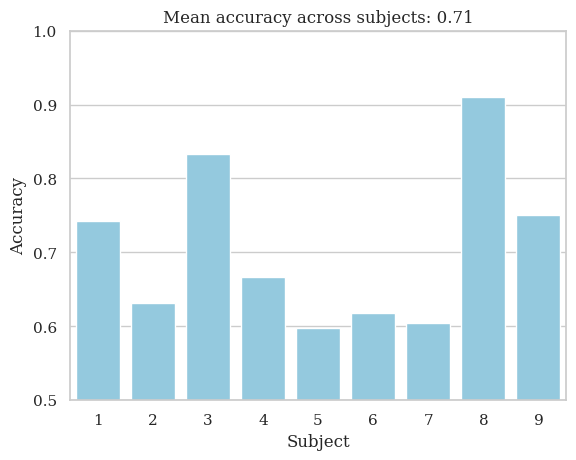

In [8]:
axes = sns.barplot(data=algorithm_1_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.5, 1)
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_1_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")

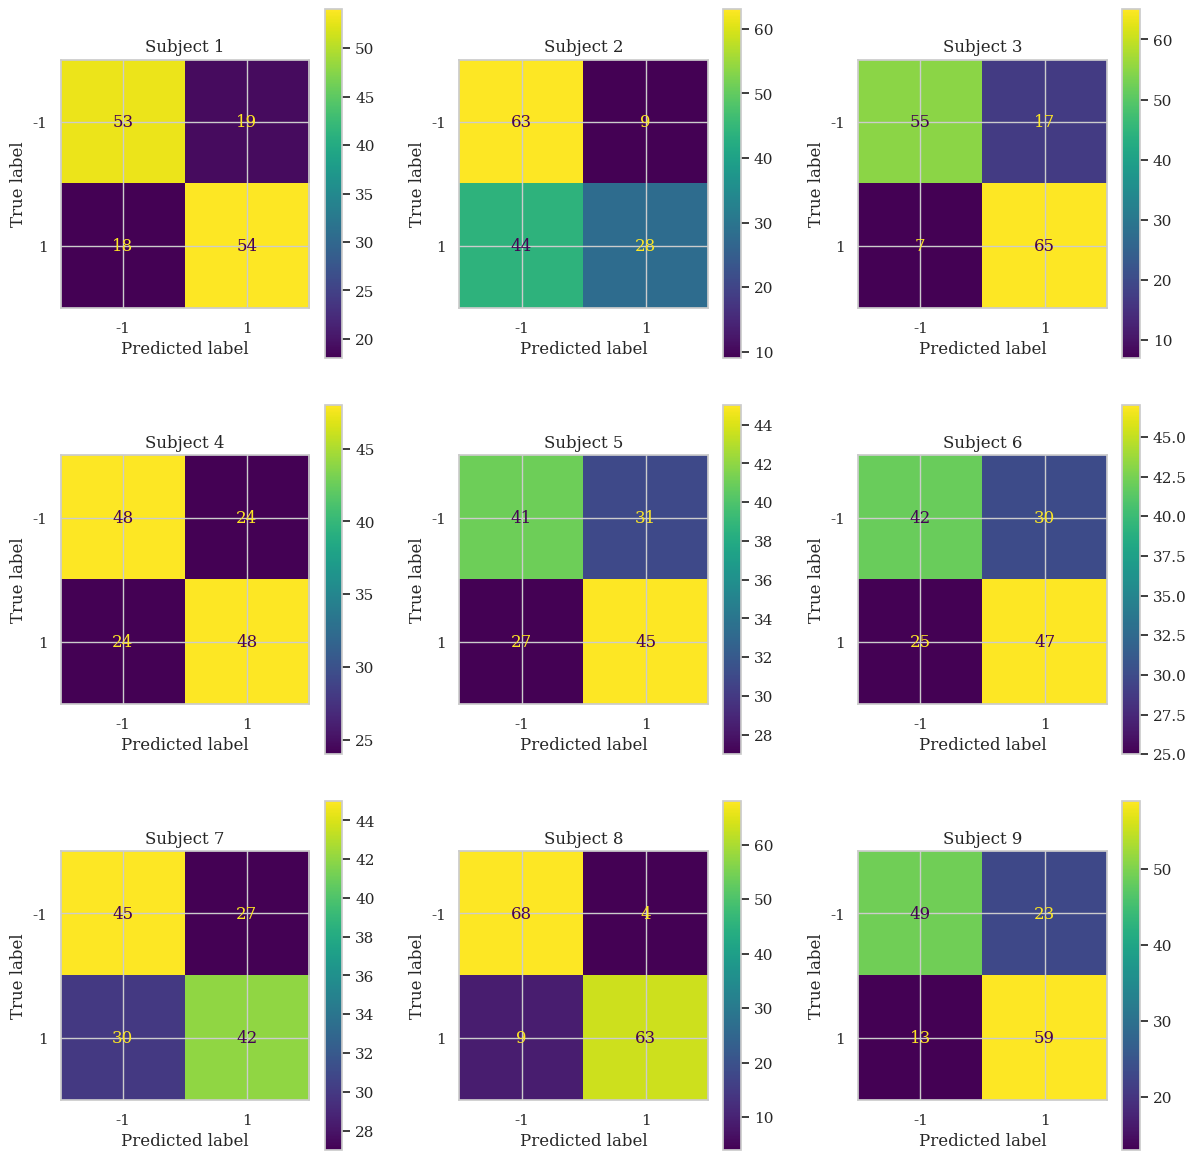

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_1_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_1_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Subject {subj_idx}")
plt.tight_layout()

# Testing linear multi-task classifier with data selection (Algorithm 2)

Testing pipeline is the same as in Algorithm 1. The only difference is data selection done when creating task-specific model.


In [60]:
reload(linear)
reload(linear_ds)

clf = linear_ds.MultiTaskLinearWithSelectionClassifier(regularization=0.2, zero_mean=False, cov_flag="l2")
clf.fit_sessions(X_train, y_train)

accuracies = []
algorithm_2_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):
    clf.fit(X_train[idx], y_train[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc)
    algorithm_2_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_2_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_2_results["accuracies"] = accuracies

2025-07-08 14:29:07,341 - INFO - Iteration 1, error = 23.949177387618455
2025-07-08 14:29:07,504 - INFO - Iteration 2, error = 4.872966031322713
2025-07-08 14:29:07,583 - INFO - Iteration 3, error = 0.2595104957929109
2025-07-08 14:29:07,653 - INFO - Iteration 4, error = 0.011673301722486162
2025-07-08 14:29:07,730 - INFO - Iteration 5, error = 0.0007032173551246473
2025-07-08 14:29:07,793 - INFO - Iteration 6, error = 6.0194064421527717e-05
2025-07-08 14:29:07,867 - INFO - Iteration 7, error = 6.508314996948542e-06
2025-07-08 14:29:07,934 - INFO - Iteration 8, error = 7.799410440739712e-07
2025-07-08 14:29:08,000 - INFO - Iteration 9, error = 9.694092720963914e-08
2025-07-08 14:29:08,070 - INFO - Iteration 10 converged, error = 1.219837321653806e-08
2025-07-08 14:29:08,075 - INFO - Selected 1 prior tasks out of 9 for new task adaptation.
2025-07-08 14:29:08,099 - INFO - Updated prior. mu new - mu old = 8.0989, sigma new - sigma old = 35.9680
2025-07-08 14:29:08,105 - INFO - Accuracy f